### NLP pada News' Topic Classification

##### Konteks:
Berita online hari ini memiliki peranan penting untuk memberikan informasi terkini tentang apa yang sedang terjadi. Kebutuhan akan informasi yang cepat ini juga harusnya dibarengi dengan proses penyaringan dan proses jurnalistik lainnya agar informasi yang dibagikan berkualitas. Salah satu proses penting adalah pemilihan topik untuk setiap berita. Selain perlu ketelitian dalam pemilihan topik yang tepat, proses ini juga memakan waktu yang tidak sebentar. Untuk tetap menyajikan berita yang terbaru dengan cepat dan berkualitas, dirasa perlu untuk menggunakan Machine learning untuk membatu percepatan proses ini. 

##### Objektif:
Penelitian ini bertujuan untuk menentukan topik dari suatu berita menggunakan kata kunci yang relevan dengan satu jenis topik

##### Latar belakang masalah:
Menentukan topik dari suatu informasi teks atau berita dengan lebih efektif.

##### Metodologi:
Untuk dapat menentukan topik yang tepat dari suatu berita, diperlukan analisis berbasis teks. Dalam kasus kali ini, metode NLP (Natural Language Processing) akan digunakan. Dengan memerhatikan kata kunci yang sering muncul dari suatu topik yang telah ditentukan di awal.

1. Memuat library yang dibutuhkan

In [3]:
## Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

## Preprocessing text
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

## Model preparation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

## Testing model
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
sns.set_style("whitegrid")

2. Memuat dataset

In [4]:
df = pd.read_csv('data.csv')
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

In [ ]:
## Melakukan pengecekan null value berdasarkan indeksnya
null_list = list(df.index[pd.isnull(df.article_content)])
null_list

[197,
 674,
 817,
 972,
 2015,
 2250,
 3276,
 4150,
 4338,
 4750,
 4838,
 4917,
 5126,
 5306,
 5859,
 5965,
 6032,
 6094,
 6442,
 6539,
 6689,
 6760,
 6816,
 6886,
 7239,
 7307,
 7403,
 7425,
 7490,
 7526,
 7920,
 8457,
 8833,
 8851,
 9552,
 9696]

3. Preprocessing dataset

In [ ]:
## Menghilangkan null data pon berisi null value
df_ready = df.drop(null_list, axis=0)
df_ready.reset_index()
df_ready.head(5)

NameError: name 'df' is not defined

In [ ]:
## Mengubah huruf kapital menjadi huruf kecil
def to_lower(text):
    return text.lower()

In [ ]:
## Menghapus text berupa angka
def remove_numbers(text):
    output = ''.join(x for x in text if not x.isdigit())
    return output

In [ ]:
## Menghilangkan tanda baca
def remove_punct(text):
    return ''.join(x for x in text if x not in punctuation)

In [ ]:
## Menghilangkan spasi berlebihan
def to_strip(text):
    return " ".join(text.split())

In [ ]:
## Menghilangkan kata-kata umun (juga, dan, yang, dll)
def remove_stopwords(sentence):
    stop_words = stopwords.words('indonesian')
    return ' '.join([x for x in nltk.word_tokenize(sentence) if not x in stop_words])

In [ ]:
## Aplikasi preprocessing pada text
df_ready['article_content_prep1'] = df_ready['article_content'].apply(to_lower)
df_ready['article_content_prep2'] = df_ready['article_content_prep1'].apply(remove_numbers)
df_ready['article_content_prep3'] = df_ready['article_content_prep2'].apply(remove_punct)
df_ready['article_content_prep4'] = df_ready['article_content_prep3'].apply(to_strip)
df_ready['article_content_prep5'] = df_ready['article_content_prep4'].apply(remove_stopwords)

df_ready.head(5)

,article_id,article_topic,article_content,article_content_prep1,article_content_prep2,article_content_prep3,article_content_prep4,article_content_prep5
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang ...,kepolisian inggris memburu pelaku meledakkan b...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan mu...,layanan transaksi jalan tol sistem nontunai ok...
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har...","\nhari ini, rabu (23/8), ternyata menjadi har...","\nhari ini, rabu (/), ternyata menjadi hari y...",\nhari ini rabu ternyata menjadi hari yang s...,hari ini rabu ternyata menjadi hari yang spesi...,rabu spesial tagar hashtag agustus menandai pa...
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan bah...,indonesia memiliki cadangan bahan bakar minyak...
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma...","hari ini, selasa (1/8), pedangdut ridho rhoma...","hari ini, selasa (/), pedangdut ridho rhoma k...",hari ini selasa pedangdut ridho rhoma kembal...,hari ini selasa pedangdut ridho rhoma kembali ...,selasa pedangdut ridho rhoma menjalani sidang ...
...,...,...,...,...,...,...,...,...
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...,reporter : joel jokoblokbojonegoro.com - har...,reporter : joel jokoblokbojonegoro.com - har...,reporter joel jokoblokbojonegorocom hari i...,reporter joel jokoblokbojonegorocom hari ini p...,reporter joel jokoblokbojonegorocom pawai buda...
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj...","pada akhir tahun ini, direktur jenderal (dirj...","pada akhir tahun ini, direktur jenderal (dirj...",pada akhir tahun ini direktur jenderal dirjen...,pada akhir tahun ini direktur jenderal dirjen ...,direktur jenderal dirjen pajak kementerian keu...
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada n...,kali barcelona neymar neymar neymar pemain mud...
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...,tim nasional (timnas) indonesia u-19 berhasil...,tim nasional (timnas) indonesia u- berhasil m...,tim nasional timnas indonesia u berhasil mera...,tim nasional timnas indonesia u berhasil merai...,tim nasional timnas indonesia u berhasil merai...


In [ ]:
## Contoh perubahan bentuk teks pada setiap aplikasi preprocessing sebelumnya
df_ready.iloc[9963]

article_id                                                        93194682
article_topic                                                    Teknologi
article_content           Telkom masih melakukan proses perbaikan dan p...
article_content_prep1     telkom masih melakukan proses perbaikan dan p...
article_content_prep2     telkom masih melakukan proses perbaikan dan p...
article_content_prep3     telkom masih melakukan proses perbaikan dan p...
article_content_prep4    telkom masih melakukan proses perbaikan dan pe...
article_content_prep5    telkom proses perbaikan pemulihan salah sateli...
Name: 9999, dtype: object

In [ ]:
## Melakukan stemming agar kata-kata yang terlalu sering muncul dieliminasi
factory = StemmerFactory()
stemming = factory.create_stemmer()
stem_all = []

for i in range(0,3):
    stem = stemming.stem(df_ready['article_content_prep5'].iloc[i])
    stem_all.append(stem)

In [ ]:
stem_all[1]

'layan transaksi jalan tol sistem nontunai oktober tingkat layan bijak terap transaksi gerbang tol efisien antre kendaraandeputi gubernur bank indonesia bi sugeng cepat penetrasi diskon persen beli kartu uang elektronik loket isi ulang kartu banyak keluh susah top up produsen tambah titik top up tingkat tahap orang mudah sugeng gedung bi thamrin jakarta selasa diskon beli kartu perdana uang elektronik agustus september tahap sedia bank mandiri bni bri bca harga kartu perdana uang elektronik ratarata rp ribu saldo rp ribu kait penetrasi guna uang elektronik nasional capai persenkepala badan atur jalan tol bpjt herry tz oktober paksa guna jalan tol uang elektronik terbit atur menteri kerja perum rakyat pupr segi atur siap atur lapang tunai ya terima tunai herrypengguna tol wajib uang elektronik oktober pt jasa marga tbk selenggara jasa jalan tol kesiap dukung program direktur operasi i jasa marga muhammad sofyan gardu tol milik jasa marga persen gardu tol otomatis gtonamun layan gardu to

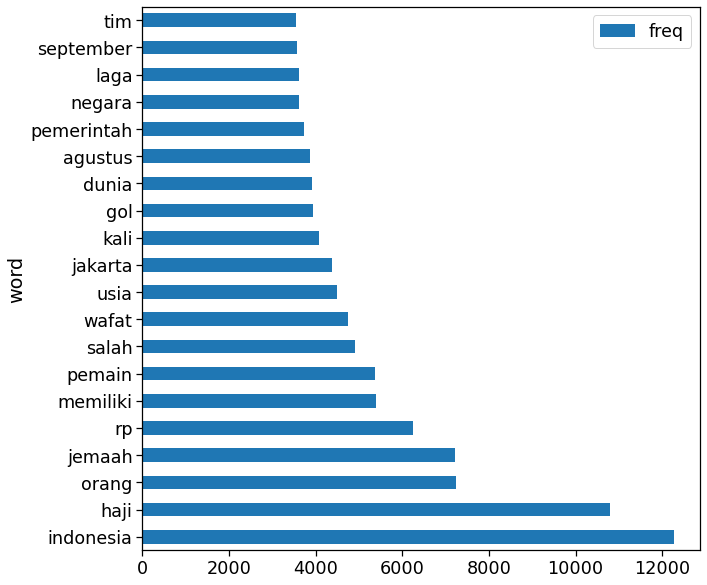

In [ ]:
## Daftar kata yang jamak pada teks
mydict_unclean = mydict(df_ready['article_content_prep5'])

sns.set_context(context = 'notebook', font_scale = 1.6)
mydict_unclean[:20].plot(kind = 'barh', figsize = (10, 10));

In [ ]:
factory = StemmerFactory()
stemming = factory.create_stemmer()
stem_all = []

for i in range(10,20):
    stem = stemming.stem(df_ready['article_content_prep5'].iloc[i])
    stem_all.append(stem)

In [ ]:
def mydict(check):
    check = check.str.extractall('([a-zA_Z]+)')
    check.columns = ['check']
    b = check.reset_index(drop=True)
    check = b['check'].value_counts()

    mydict = {'word':check.index,'freq':check.values}
    mydict = pd.DataFrame(mydict)
    mydict.index = mydict['word']
    mydict.drop('word', axis = 1, inplace = True)
    mydict.sort_values('freq', ascending=False, inplace=True)
    
    return mydict

In [ ]:
## Melihat daftar topik unik pada dataset
topics = df_ready['article_topic'].unique()
topics

array(['Internasional', 'Ekonomi', 'Teknologi', 'Hiburan', 'Haji',
       'Travel', 'Personal', 'Sepak Bola', 'Health', 'Sports', 'Politik',
       'Otomotif', 'KPK', 'Lifestyle', 'Keuangan', 'Sejarah', 'Regional',
       'Pendidikan', 'Hukum', 'Obat-obatan', 'Bojonegoro', 'Kesehatan',
       'Horor', 'Bisnis', 'MotoGP', 'Sains', 'Jakarta', 'Pilgub Jatim',
       'K-Pop'], dtype=object)

In [ ]:
df_preprocess = df_ready[['article_id','article_topic','article_content_prep5']]
df_preprocess

,article_id,article_topic,article_content_prep5
0,93205794,Internasional,kepolisian inggris memburu pelaku meledakkan b...
1,93186698,Ekonomi,layanan transaksi jalan tol sistem nontunai ok...
2,93191463,Teknologi,rabu spesial tagar hashtag agustus menandai pa...
3,93219292,Ekonomi,indonesia memiliki cadangan bahan bakar minyak...
4,343106,Hiburan,selasa pedangdut ridho rhoma menjalani sidang ...
...,...,...,...
9995,93221319,Bojonegoro,reporter joel jokoblokbojonegorocom pawai buda...
9996,93203115,Ekonomi,direktur jenderal dirjen pajak kementerian keu...
9997,93230854,Sepak Bola,kali barcelona neymar neymar neymar pemain mud...
9998,93199312,Sepak Bola,tim nasional timnas indonesia u berhasil merai...


In [ ]:
X = df_preprocess['article_content_prep5']
y = df_preprocess['art_encode']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.2,
    stratify = y,
    random_state = 0)

In [ ]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

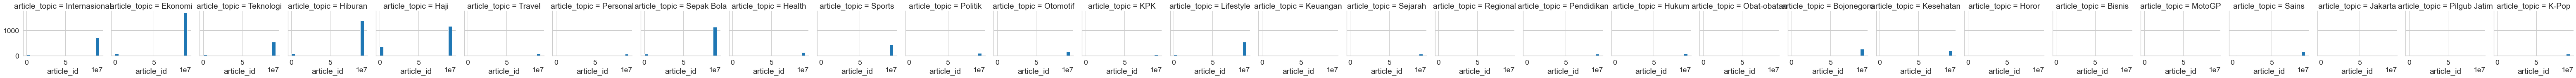

In [ ]:
age_alive = sns.FacetGrid(df, col='article_topic')
age_alive.map(plt.hist, 'article_id', bins=20)
plt.show()

In [ ]:
df['article_topic'].value_counts()

Ekonomi          1762
Haji             1497
Hiburan          1466
Sepak Bola       1184
Internasional     741
Lifestyle         572
Teknologi         571
Sports            435
Bojonegoro        260
Kesehatan         195
Sains             174
Otomotif          174
Health            131
Politik           104
Hukum              85
Personal           81
Travel             76
Sejarah            70
Pendidikan         70
K-Pop              61
Obat-obatan        58
Horor              50
KPK                37
MotoGP             35
Regional           35
Bisnis             25
Pilgub Jatim       25
Keuangan           14
Jakarta            12
Name: article_topic, dtype: int64

In [ ]:
df.head(5)

,article_id,article_topic,article_content
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har..."
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma..."
...,...,...,...
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj..."
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...


/Users/yoga/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


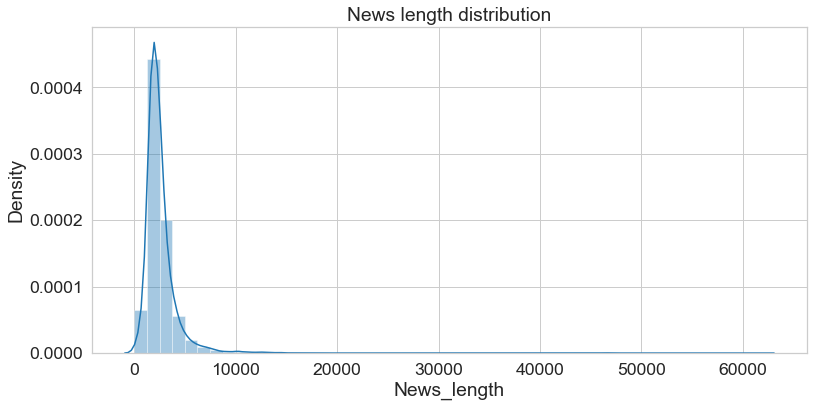

In [ ]:
## Melihat komposisi penjang teks pada dataset
plt.figure(figsize=(12.8,6))
sns.distplot(df['News_length']).set_title('News length distribution');

In [ ]:
df_ready

,article_id,article_topic,article_content,article_content_prep1,article_content_prep2,article_content_prep3,article_content_prep4,article_content_prep5
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang ...,kepolisian inggris memburu pelaku meledakkan b...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan mu...,layanan transaksi jalan tol sistem nontunai ok...
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har...","\nhari ini, rabu (23/8), ternyata menjadi har...","\nhari ini, rabu (/), ternyata menjadi hari y...",\nhari ini rabu ternyata menjadi hari yang s...,hari ini rabu ternyata menjadi hari yang spesi...,rabu spesial tagar hashtag agustus menandai pa...
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan bah...,indonesia memiliki cadangan bahan bakar minyak...
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma...","hari ini, selasa (1/8), pedangdut ridho rhoma...","hari ini, selasa (/), pedangdut ridho rhoma k...",hari ini selasa pedangdut ridho rhoma kembal...,hari ini selasa pedangdut ridho rhoma kembali ...,selasa pedangdut ridho rhoma menjalani sidang ...
...,...,...,...,...,...,...,...,...
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...,reporter : joel jokoblokbojonegoro.com - har...,reporter : joel jokoblokbojonegoro.com - har...,reporter joel jokoblokbojonegorocom hari i...,reporter joel jokoblokbojonegorocom hari ini p...,reporter joel jokoblokbojonegorocom pawai buda...
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj...","pada akhir tahun ini, direktur jenderal (dirj...","pada akhir tahun ini, direktur jenderal (dirj...",pada akhir tahun ini direktur jenderal dirjen...,pada akhir tahun ini direktur jenderal dirjen ...,direktur jenderal dirjen pajak kementerian keu...
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada n...,kali barcelona neymar neymar neymar pemain mud...
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...,tim nasional (timnas) indonesia u-19 berhasil...,tim nasional (timnas) indonesia u- berhasil m...,tim nasional timnas indonesia u berhasil mera...,tim nasional timnas indonesia u berhasil merai...,tim nasional timnas indonesia u berhasil merai...


In [ ]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
stop_rem = []

for i in range(0,9964):
    stop_sastrawi = stopword.remove(df_ready['article_content_prep5'].iloc[i])
    stop_rem.append(stop_sastrawi)

In [ ]:
len(stop_rem)

9964

In [ ]:
df_ready['article_content_stem_rem'] = stop_rem

In [ ]:
df_ready

,article_id,article_topic,article_content,article_content_prep1,article_content_prep2,article_content_prep3,article_content_prep4,article_content_prep5,article_content_result,article_content_stem_rem
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku yang ...,kepolisian inggris memburu pelaku meledakkan b...,kepolisian inggris memburu pelaku meledakkan b...,kepolisian inggris memburu pelaku meledakkan b...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi di jalan tol akan mu...,layanan transaksi jalan tol sistem nontunai ok...,layanan transaksi jalan tol sistem nontunai ok...,layanan transaksi jalan tol sistem nontunai ok...
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har...","\nhari ini, rabu (23/8), ternyata menjadi har...","\nhari ini, rabu (/), ternyata menjadi hari y...",\nhari ini rabu ternyata menjadi hari yang s...,hari ini rabu ternyata menjadi hari yang spesi...,rabu spesial tagar hashtag agustus menandai pa...,rabu spesial tagar hashtag agustus menandai pa...,rabu spesial tagar hashtag agustus menandai pa...
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan ba...,saat ini indonesia hanya memiliki cadangan bah...,indonesia memiliki cadangan bahan bakar minyak...,indonesia memiliki cadangan bahan bakar minyak...,indonesia memiliki cadangan bahan bakar minyak...
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma...","hari ini, selasa (1/8), pedangdut ridho rhoma...","hari ini, selasa (/), pedangdut ridho rhoma k...",hari ini selasa pedangdut ridho rhoma kembal...,hari ini selasa pedangdut ridho rhoma kembali ...,selasa pedangdut ridho rhoma menjalani sidang ...,selasa pedangdut ridho rhoma menjalani sidang ...,selasa pedangdut ridho rhoma menjalani sidang ...
...,...,...,...,...,...,...,...,...,...,...
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...,reporter : joel jokoblokbojonegoro.com - har...,reporter : joel jokoblokbojonegoro.com - har...,reporter joel jokoblokbojonegorocom hari i...,reporter joel jokoblokbojonegorocom hari ini p...,reporter joel jokoblokbojonegorocom pawai buda...,reporter joel jokoblokbojonegorocom pawai buda...,reporter joel jokoblokbojonegorocom pawai buda...
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj...","pada akhir tahun ini, direktur jenderal (dirj...","pada akhir tahun ini, direktur jenderal (dirj...",pada akhir tahun ini direktur jenderal dirjen...,pada akhir tahun ini direktur jenderal dirjen ...,direktur jenderal dirjen pajak kementerian keu...,direktur jenderal dirjen pajak kementerian keu...,direktur jenderal dirjen pajak kementerian keu...
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada ...,ketika pertama kali datang ke barcelona pada n...,kali barcelona neymar neymar neymar pemain mud...,kali barcelona neymar neymar neymar pemain mud...,kali barcelona neymar neymar neymar pemain mud...
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...,tim nasional (timnas) indonesia u-19 berhasil...,tim nasional (timnas) indonesia u- berhasil m...,tim nasional timnas indonesia u berhasil mera...,tim nasional timnas indonesia u berhasil merai...,tim nasional timnas indonesia u berhasil merai...,tim nasional timnas indonesia u berhasil merai...,tim nasional timnas indonesia u be

In [ ]:
list_columns = ['article_id','article_topic','article_content','article_content_stem_rem']
df_preprocess = df_ready[list_columns]

df_preprocess = df_preprocess.rename(columns={'article_content_stem_rem': 'article_content_result'})

In [ ]:
df_preprocess

,article_id,article_topic,article_content,article_content_result
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...,kepolisian inggris memburu pelaku meledakkan b...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...,layanan transaksi jalan tol sistem nontunai ok...
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har...",rabu spesial tagar hashtag agustus menandai pa...
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...,indonesia memiliki cadangan bahan bakar minyak...
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma...",selasa pedangdut ridho rhoma menjalani sidang ...
...,...,...,...,...
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...,reporter joel jokoblokbojonegorocom pawai buda...
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj...",direktur jenderal dirjen pajak kementerian keu...
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...,kali barcelona neymar neymar neymar pemain mud...
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...,tim nasional timnas indonesia u berhasil merai...


In [ ]:
category_codes = {
        'Internasional':0, 
        'Ekonomi':1,
        'Teknologi':2,
        'Hiburan':3,
        'Haji':4,
        'Travel':5,
        'Personal':6,
        'Sepak Bola':7,
        'Health':8,
        'Sports':9,
        'Politik':10,
        'Otomotif':11,
        'KPK':12,
        'Lifestyle':13,
        'Keuangan':14,
        'Sejarah':15,
        'Regional':16,
        'Pendidikan':17,
        'Hukum':18, 
        'Obat-obatan':19, 
        'Bojonegoro':20, 
        'Kesehatan':21,
        'Horor':22, 
        'Bisnis':23, 
        'MotoGP':24, 
        'Sains':25, 
        'Jakarta':26, 
        'Pilgub Jatim':27,
        'K-Pop':28
}

In [ ]:
## Memberikan label numerikal untuk setiap topik
df_preprocess['topic_type'] = df_preprocess['article_topic']
df_preprocess = df_preprocess.replace({'topic_type':category_codes})

In [ ]:
df_preprocess

,article_id,article_topic,article_content,article_content_result,topic_type
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...,kepolisian inggris memburu pelaku meledakkan b...,0
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...,layanan transaksi jalan tol sistem nontunai ok...,1
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har...",rabu spesial tagar hashtag agustus menandai pa...,2
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...,indonesia memiliki cadangan bahan bakar minyak...,1
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma...",selasa pedangdut ridho rhoma menjalani sidang ...,3
...,...,...,...,...,...
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...,reporter joel jokoblokbojonegorocom pawai buda...,20
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj...",direktur jenderal dirjen pajak kementerian keu...,1
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...,kali barcelona neymar neymar neymar pemain mud...,7
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...,tim nasional timnas indonesia u berhasil merai...,7


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_preprocess['article_content_result'], 
                                                    df_preprocess['topic_type'],
                                                    test_size=0.25, 
                                                    random_state=0)

In [ ]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [ ]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(7473, 300)
(2491, 300)


In [ ]:
for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'Bisnis' category:
  . Most correlated unigrams:
. produk
. ekonomi
. usaha
. harga
. bisnis
  . Most correlated bigrams:
. arab saudi
. jemaah haji

# 'Bojonegoro' category:
  . Most correlated unigrams:
. timur
. warga
. kabupaten
. desa
. bojonegoro
  . Most correlated bigrams:
. jemaah haji
. kumparan kumparancom

# 'Ekonomi' category:
  . Most correlated unigrams:
. perdagangan
. rp
. pt
. bank
. saham
  . Most correlated bigrams:
. dolar as
. rp triliun

# 'Haji' category:
  . Most correlated unigrams:
. kloter
. mch
. jamaah
. jemaah
. haji
  . Most correlated bigrams:
. haji indonesia
. jemaah haji

# 'Health' category:
  . Most correlated unigrams:
. jelly
. qnc
. penyakit
. gamat
. obat
  . Most correlated bigrams:
. pembuluh darah
. jelly gamat

# 'Hiburan' category:
  . Most correlated unigrams:
. pernikahan
. berusia
. lagu
. aja
. film
  . Most correlated bigrams:
. arab saudi
. jemaah haji

# 'Horor' category:
  . Most correlated unigrams:
. bernama
. meninggal
. warga

In [ ]:
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
logreg = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=0)
svm = svm.SVC(random_state=0)
gbm = GradientBoostingClassifier(random_state = 0)

models = [knn, tree, logreg, rf, svm, gbm]
score = []
nilai_mean = []
nilai_std = []

for i in models:
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
   
    model_cv = cross_val_score(i, features_train, labels_train, cv=skfold, scoring='accuracy', error_score='raise')
    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [ ]:
pd.DataFrame({
    'model':['knn', 'tree', 'logreg', 'rf', 'svm', 'gbm'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,knn,0.658904,0.009761
1,tree,0.674162,0.008302
2,logreg,0.791248,0.004011
3,rf,0.786029,0.008481
4,svm,0.807573,0.007106
5,gbm,0.749365,0.011719


In [ ]:
svc_0 =svm.SVC(random_state=0)

print('Parameters currently in use:\n')
print(svc_0.get_params())

Parameters currently in use:

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
C = [.0001, .001, .01, .1, 1, 10]

gamma = [.0001, .001, .01, .1, 1, 10, 100, 'scale']

degree = [1, 2, 3, 4, 5]

kernel = ['linear', 'poly', 'rbf', 'sigmoid']

probability = [True,False]

random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }


In [ ]:
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=0)

random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(random_state=0), n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 'scale'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True, False]},
                   random_state=0, scoring='accuracy', verbose=1)

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': False, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 10}

The mean accuracy of a model with these hyperparameters is:
0.808644453365449


In [ ]:
best_svc = random_search.best_estimator_
best_svc

SVC(C=10, degree=2, random_state=0)

In [ ]:
best_svc.fit(features_train, labels_train)

SVC(C=10, degree=2, random_state=0)

In [ ]:
svc_pred = best_svc.predict(features_test)

In [ ]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.996922253445738


In [ ]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.8402248093135287


In [ ]:
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       185
           1       0.86      0.97      0.92       440
           2       0.86      0.84      0.85       142
           3       0.83      0.93      0.88       362
           4       0.99      0.99      0.99       374
           5       0.55      0.32      0.40        19
           6       0.40      0.10      0.16        20
           7       0.85      0.94      0.89       295
           8       0.55      0.55      0.55        33
           9       0.70      0.55      0.62       109
          10       0.75      0.46      0.57        26
          11       0.88      0.70      0.78        43
          12       1.00      0.78      0.88         9
          13       0.71      0.75      0.73       142
          14       0.00      0.00      0.00         4
          15       0.75      0.35      0.48        17
          16       0.00      0.00      0.00         9
     

/Users/yoga/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoga/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoga/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_preprocess

,article_id,article_topic,article_content,article_content_result,topic_type
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...,kepolisian inggris memburu pelaku meledakkan b...,0
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...,layanan transaksi jalan tol sistem nontunai ok...,1
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har...",rabu spesial tagar hashtag agustus menandai pa...,2
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...,indonesia memiliki cadangan bahan bakar minyak...,1
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma...",selasa pedangdut ridho rhoma menjalani sidang ...,3
...,...,...,...,...,...
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...,reporter joel jokoblokbojonegorocom pawai buda...,20
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj...",direktur jenderal dirjen pajak kementerian keu...,1
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...,kali barcelona neymar neymar neymar pemain mud...,7
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...,tim nasional timnas indonesia u berhasil merai...,7


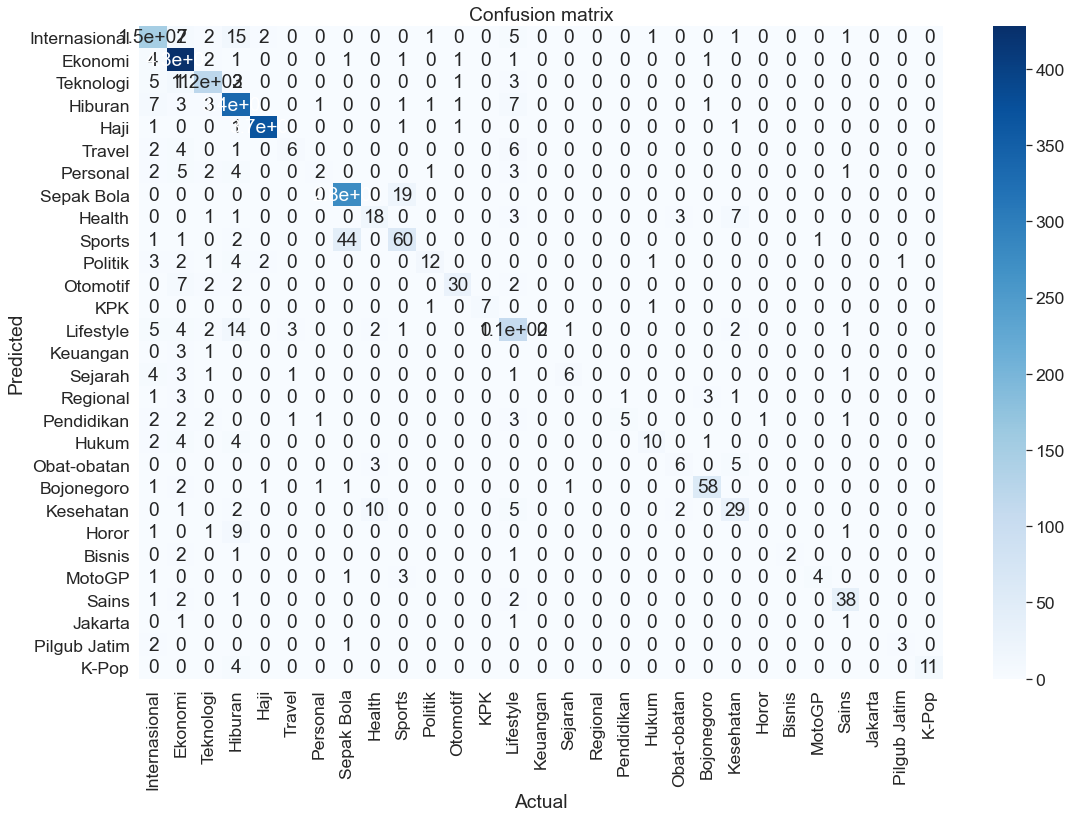

In [ ]:
aux_df = df_preprocess[['article_topic', 'topic_type']].drop_duplicates().sort_values('topic_type')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(18,12))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['article_topic'].values, 
            yticklabels=aux_df['article_topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
random_search.best_estimator_.fit(features_train, labels_train)
filename = 'Model Final.sav'
pickle.dump(random_search.best_estimator_,open(filename,'wb'))

filename = 'tfidf.sav'
pickle.dump(tfidf,open(filename,'wb'))

In [ ]:
features_test

array([[0.        , 0.25260266, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.1344116 , ..., 0.        , 0.        ,
        0.15563685],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
pickle.dump(best_svc, open('model.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))